In [6]:
% pip install geopandas

     |████████████████████████████████| 1.0 MB 13.7 MB/s 
     |████████████████████████████████| 16.7 MB 58.7 MB/s 
     |████████████████████████████████| 6.3 MB 58.2 MB/s 


In [ ]:
% pip install earthpy

     |████████████████████████████████| 1.4 MB 4.7 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import earthpy as etpy

In [3]:
import ee
import folium

In [4]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=3jQm9rReKUfg827CHCJy3GMGnVgBHpOaW9JpYIJEKFs&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWipSM2tJAsWQmBE1KF5XDToTzrodyrDdI4DYGWcD0fqPm7jRkuGP7g

Successfully saved authorization token.


In [ ]:
# import shapefile using geopandas
coastline_gdf = gpd.read_file("/content/drive/My Drive/Coastline_Antarctica/Coastline_Antarctica_v02.shp")
print(type(coastline_gdf))
coastline_gdf.head(1)

<class 'geopandas.geodataframe.GeoDataFrame'>


,NAME,geometry
0,Coastline,"POLYGON ((-1584579.956 902423.000, -1584579.95..."


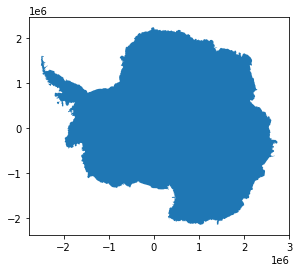

In [ ]:
coastline_gdf.plot()

In [ ]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              71.9121,
              -69.8065
            ],
            [
              78.3803,
              -69.8065
            ],
            [
              78.3803,
              -66.9398
            ],
            [
              71.9121,
              -66.9398
            ],
            [
              71.9121,
              -69.8065
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
# print(type(coords))
# print(aoi)

In [ ]:
# converting shapefile to geoJSON using geopandas
coastline_geoJSON = gpd.GeoSeries([coastline_gdf.geometry.iloc[0]]).__geo_interface__
coastline_coords = coastline_geoJSON['features'][0]['geometry']['coordinates']
coastline = ee.Geometry.Polygon(coastline_coords)
coastlinecd = coastline.coordinates()
# print(coastline_coords)
# print(coastlinecd)

In [ ]:
S1A = ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(aoi).filterDate(ee.Date('2019-11-24'),ee.Date('2019-11-25'))

In [ ]:
image = S1A.first()
my_map = folium.Map(location=[-68.0984, 74.0947], zoom_start=6)

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer
vis_params = {
  'bands': "HH",
  'min': -30,
  'max': 0,}
my_map.add_ee_layer(image, vis_params, "image1")
my_map.add_child(folium.LayerControl())
display(my_map)

In [ ]:
from ee.featurecollection import FeatureCollection
# from ee_plugin import Map
feature = FeatureCollection('projects/ee-jay/assets/Coastline_Antarctica_v02')
my_map1 = folium.Map(location=[-68.0984, 74.0947], zoom_start=6)
def addlayer(self, ee_feature_object, vis_params, name):
  map_id_dict = ee.FeatureCollection(ee_feature_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

folium.Map.addlayer = addlayer

my_map1.addlayer(feature, vis_params, "image2")
my_map1.add_ee_layer(image, vis_params, "image1")
my_map1.add_child(folium.LayerControl())
display(my_map1)

In [ ]:
clipped_image = image.clip(feature)
my_map2 = folium.Map(location=[-68.0984, 74.0947], zoom_start=6)
my_map2.add_ee_layer(image, vis_params, "image1")
my_map2.add_ee_layer(clipped_image, vis_params, "image2")

xor_image = image.bitwiseXor(clipped_image)
print(type(xor_image))
maskedimage = image.updateMask(xor_image)
my_map2.add_ee_layer(maskedimage, vis_params, "image3")

my_map2.add_child(folium.LayerControl())
display(my_map2)

<class 'ee.image.Image'>


EEException: ignored

In [3]:
# read geojson file and extract centroid information
import pandas as pd
# import geopandas as gpd
# import fiona

# gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
df = pd.read_json('/content/drive/My Drive/Iceberg_tracking/Iceberg_2019-11-14.geojson')
df
features = df.iloc[0]['features']
features['properties']['refdate']
# json = gpd.GeoSeries([df.centroid.iloc[0]]).__geo_interface__
# print(json)
# iceberg_coords = json['features'][0]['geometry']['coordinates']
# # def addArea(feature):
#   return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});
# iceberg = ee.FeatureCollection(ee.Geometry.Polygon(iceberg_coords))
# abc = iceberg.map(addArea)
# features = abc.getInfo()['features']
# # coastlinecd = coastline.coordinates()
# centroid = features['properties']['centroid']['coordinates']

# centroid

'2019-11-01'

In [13]:
% pip install fastkml

     |████████████████████████████████| 62 kB 1.0 MB/s 
  Created wheel for pygeoif: filename=pygeoif-0.7-py3-none-any.whl size=19248 sha256=acf104b3c3ad29613c170e053dade30718335b5a0f9e1c9469ca5b40e60da98c
  Stored in directory: /root/.cache/pip/wheels/4a/84/19/a1fcaf92f8f57a424eca18e2d8c03d149436806b91474bcb89
Successfully built pygeoif


In [45]:
# not needed
from fastkml import kml
with open("/content/drive/My Drive/Iceberg_tracking/Iceberg_2019-11-16.kml", 'rt', encoding="utf-8") as myfile:
  doc = myfile.read()

  print(doc)
  k = kml.KML()
  k.from_string(doc.encode('utf-8'))
  features = list(k.features())
  f2 = list(features[0].features())
  f3 = list(f2[0].features())
  print(f3)

<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2">
<Document>
<Placemark>
  <ExtendedData>
    <Data name='area'>
      <value>1.6044612732290094E9</value>
    </Data>
    <Data name='similarity'>
      <value>0.9900104231042403</value>
    </Data>
    <Data name='centroid'>
      <value>{"type":"Point","coordinates":[70.91539096932195,-68.22942174131876]}</value>
    </Data>
    <Data name='refdate'>
      <value>2019-11-01</value>
    </Data>
    <Data name='system:index'>
      <value>0</value>
    </Data>
  </ExtendedData>
  <MultiGeometry>
    <Polygon>
      <outerBoundaryIs>
        <LinearRing>
          <coordinates>70.62698494193137,-68.3596371648137 70.63129685529515,-68.3596371648137 70.63129685529515,-68.35999649092734 70.63273415974975,-68.35999649092734 70.63273415974975,-68.360355817041 70.63524944254527,-68.360355817041 70.63524944254527,-68.36071514315465 70.63596809477256,-68.36071514315465 70.63596809477256,-68.36107446926829 70.6363

AttributeError: ignored